In [1]:
import torch
import math
from torch import nn
from torch.nn import functional as F

In [2]:
class MLP(nn.Module):
    def __init__(self, dim, tp, dim_ratio=3.5, dtype=torch.bfloat16):
        super().__init__()
        out_dim = int(dim * dim_ratio // tp)
        self.fc1 = nn.Linear(dim, out_dim, dtype=dtype)
        self.act_fn = nn.ReLU()
        self.fc2 = nn.Linear(out_dim, dim, dtype=dtype)
        self.dim_shape = (dim, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        return x

In [3]:
def timed(fn):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end)

In [4]:
torch.cuda.empty_cache()

In [7]:
import pickle
with open("mlp.data.pkl", "rb") as f:
    compiled_dict = pickle.load(f)


In [8]:
# compiled_dict = {}
compiled_dict

{(1, 10, 1, 3.5): (0.1457855999469757, 0.0038975659563954745),
 (1, 11, 1, 3.5): (0.13249920308589935, 0.0053744985950351775),
 (1, 12, 1, 3.5): (0.219379198551178, 0.0012953625852419252),
 (1, 13, 1, 3.5): (0.6323583841323852, 0.005566718960827771),
 (1, 14, 1, 3.5): (2.2815231800079347, 0.007290782771374383),
 (2, 10, 1, 3.5): (0.14785920083522797, 0.001733396619267982),
 (2, 11, 1, 3.5): (0.14794239699840545, 0.0011924279258262408),
 (2, 12, 1, 3.5): (0.23313920199871063, 0.0007337967559663881),
 (2, 13, 1, 3.5): (0.6419839978218078, 0.003512763690832288),
 (2, 14, 1, 3.5): (2.3048959255218504, 0.004762439300157712),
 (3, 10, 1, 3.5): (0.15066879689693452, 0.005660892991582651),
 (3, 11, 1, 3.5): (0.1592768043279648, 0.004096729451535047),
 (3, 12, 1, 3.5): (0.24302720427513122, 0.0019234744678647895),
 (3, 13, 1, 3.5): (0.6478847861289978, 0.004492719828861247),
 (3, 14, 1, 3.5): (2.3169408321380613, 0.005645637268193552),
 (4, 10, 1, 3.5): (0.16801919937133789, 0.01176184445647220

In [9]:
torch.cuda.empty_cache()

In [10]:
device = torch.device("cuda:0")

In [11]:
from tqdm import tqdm

In [12]:
configs = []
for batch_size_factor in range(1, 20):
    for dim_factor in range(10, 15):
        for tp in [1]:
            for dim_ratio in [3.5]:
                configs.append((batch_size_factor, dim_factor, tp, dim_ratio))

# configs.sort(key=lambda x: x[0] * ((2 ** x[1]) * ((2 ** x[1] * dim_ratio))) / x[2])

In [13]:
import torch._dynamo as dynamo
dynamo.config.cache_size_limit = 256

In [14]:
def mlp_flops_bytes(batch_size: int, in_dim: int, out_dim: int, dtype_size: int = 2):
    # flops = 2 matmul
    flops = 4 * batch_size * in_dim * out_dim
    # mem = x + x + Wup + Wdown
    mem = (2 * batch_size * in_dim + 2 * in_dim * out_dim) * dtype_size
    return flops, mem

def mlp_ai(batch_size: int, in_dim: int, out_dim: int, dtype_size: int = 2):
    flops, mem = mlp_flops_bytes(batch_size, in_dim, out_dim, dtype_size)
    return flops / mem

In [15]:
def get_est_time(batch_size: int, in_dim: int, out_dim: int, dtype_size: int = 2):
    flops, mem = mlp_flops_bytes(batch_size, in_dim, out_dim, dtype_size)
    ai = flops / mem
    # T = 10 ** 12
    T = 2 ** 40
    a100_flops = 312 * T
    a100_mem = 1.5 * T
    a100_ai = a100_flops / a100_mem
    is_flops_bound = ai > a100_ai

    est_time = flops / a100_flops * 1000 + mem / a100_mem * 1000
    return est_time


In [18]:
# for config in tqdm(configs, desc="Running configs"):

with torch.no_grad():
    for config in tqdm(configs, desc="Running configs"):
        if config in compiled_dict:
            continue
        batch_size_factor, dim_factor, tp, dim_ratio = config
        batch_size = 2 ** batch_size_factor
        dim = 2 ** dim_factor
        mlp = MLP(dim, tp, dim_ratio).to(device)
        mlp.compile()
        N_ITERS = 10
        compile_times = []
        x = torch.randn(batch_size, dim, device=device, dtype=torch.bfloat16)
        for i in range(N_ITERS):
            # _, compile_time = timed(lambda: torch.multiprocessing.spawn(lambda _: mlp(x), nprocs=1)[0])
            _, compile_time = timed(lambda : mlp(x))
            compile_times.append(compile_time)
            # print(f"Compile eval time (x.shape: {x.shape}) {i}: {compile_time:.3f}")
        compile_times = compile_times[-5:]
        
        avg_time = sum(compile_times) / len(compile_times)
        std_time = math.sqrt(sum((time - avg_time) ** 2 for time in compile_times) / len(compile_times))
        throughput = batch_size / avg_time * 1000 # token per second

        flops, mem = mlp_flops_bytes(batch_size, dim, dim * dim_ratio, dtype_size=2)
        ai = flops / mem
        est_time = get_est_time(batch_size, dim, dim * dim_ratio, dtype_size=2)

        compiled_dict[config] = (avg_time, std_time)
        print(f"MLP(dim={dim}, tp={tp}) (shape = {tuple(x.shape)}) {avg_time:.2f} ms ± {std_time:.2f} [tokens/s: {throughput:.2f}] [est_time: {est_time:.2f}] [ai: {ai:.2f}] [flops: {flops:.2f}] [mem: {mem:.2f}]")
        # print("~" * 10)
        torch.cuda.empty_cache()

Running configs:   1%|          | 1/95 [00:06<10:33,  6.74s/it]

MLP(dim=1024, tp=1) (shape = (2, 1024)) 0.15 ms ± 0.00 [tokens/s: 13718.78] [est_time: 9.79] [ai: 2.00] [flops: 29360128.00] [mem: 14688256.00]


Running configs:   2%|▏         | 2/95 [00:07<05:20,  3.45s/it]

MLP(dim=2048, tp=1) (shape = (2, 2048)) 0.13 ms ± 0.01 [tokens/s: 15094.43] [est_time: 39.16] [ai: 2.00] [flops: 117440512.00] [mem: 58736640.00]


Running configs:   3%|▎         | 3/95 [00:09<04:02,  2.63s/it]

MLP(dim=4096, tp=1) (shape = (2, 4096)) 0.22 ms ± 0.00 [tokens/s: 9116.63] [est_time: 156.61] [ai: 2.00] [flops: 469762048.00] [mem: 234913792.00]


Running configs:   4%|▍         | 4/95 [00:13<04:37,  3.05s/it]

MLP(dim=8192, tp=1) (shape = (2, 8192)) 0.63 ms ± 0.01 [tokens/s: 3162.76] [est_time: 626.39] [ai: 2.00] [flops: 1879048192.00] [mem: 939589632.00]


Running configs:   5%|▌         | 5/95 [00:25<09:18,  6.21s/it]

MLP(dim=16384, tp=1) (shape = (2, 16384)) 2.28 ms ± 0.01 [tokens/s: 876.61] [est_time: 2505.48] [ai: 2.00] [flops: 7516192768.00] [mem: 3758227456.00]


Running configs:   6%|▋         | 6/95 [00:25<06:24,  4.32s/it]

MLP(dim=1024, tp=1) (shape = (4, 1024)) 0.15 ms ± 0.00 [tokens/s: 27052.76] [est_time: 9.80] [ai: 4.00] [flops: 58720256.00] [mem: 14696448.00]


Running configs:   7%|▋         | 7/95 [00:26<04:37,  3.15s/it]

MLP(dim=2048, tp=1) (shape = (4, 2048)) 0.15 ms ± 0.00 [tokens/s: 27037.55] [est_time: 39.17] [ai: 4.00] [flops: 234881024.00] [mem: 58753024.00]


Running configs:   8%|▊         | 8/95 [00:27<03:41,  2.54s/it]

MLP(dim=4096, tp=1) (shape = (4, 4096)) 0.23 ms ± 0.00 [tokens/s: 17157.13] [est_time: 156.63] [ai: 4.00] [flops: 939524096.00] [mem: 234946560.00]


Running configs:   9%|▉         | 9/95 [00:31<04:02,  2.82s/it]

MLP(dim=8192, tp=1) (shape = (4, 8192)) 0.64 ms ± 0.00 [tokens/s: 6230.68] [est_time: 626.44] [ai: 4.00] [flops: 3758096384.00] [mem: 939655168.00]


Running configs:  11%|█         | 10/95 [00:42<07:44,  5.47s/it]

MLP(dim=16384, tp=1) (shape = (4, 16384)) 2.30 ms ± 0.00 [tokens/s: 1735.44] [est_time: 2505.57] [ai: 4.00] [flops: 15032385536.00] [mem: 3758358528.00]
MLP(dim=1024, tp=1) (shape = (8, 1024)) 0.15 ms ± 0.01 [tokens/s: 53096.59] [est_time: 9.81] [ai: 7.98] [flops: 117440512.00] [mem: 14712832.00]


Running configs:  13%|█▎        | 12/95 [00:42<04:05,  2.96s/it]

MLP(dim=2048, tp=1) (shape = (8, 2048)) 0.16 ms ± 0.00 [tokens/s: 50227.02] [est_time: 39.19] [ai: 7.99] [flops: 469762048.00] [mem: 58785792.00]


Running configs:  14%|█▎        | 13/95 [00:43<03:15,  2.39s/it]

MLP(dim=4096, tp=1) (shape = (8, 4096)) 0.24 ms ± 0.00 [tokens/s: 32918.13] [est_time: 156.67] [ai: 8.00] [flops: 1879048192.00] [mem: 235012096.00]


Running configs:  15%|█▍        | 14/95 [00:46<03:20,  2.47s/it]

MLP(dim=8192, tp=1) (shape = (8, 8192)) 0.65 ms ± 0.00 [tokens/s: 12347.87] [est_time: 626.52] [ai: 8.00] [flops: 7516192768.00] [mem: 939786240.00]


Running configs:  16%|█▌        | 15/95 [00:56<06:19,  4.75s/it]

MLP(dim=16384, tp=1) (shape = (8, 16384)) 2.32 ms ± 0.01 [tokens/s: 3452.83] [est_time: 2505.75] [ai: 8.00] [flops: 30064771072.00] [mem: 3758620672.00]
MLP(dim=1024, tp=1) (shape = (16, 1024)) 0.17 ms ± 0.01 [tokens/s: 95227.21] [est_time: 9.83] [ai: 15.93] [flops: 234881024.00] [mem: 14745600.00]


Running configs:  18%|█▊        | 17/95 [00:57<03:31,  2.71s/it]

MLP(dim=2048, tp=1) (shape = (16, 2048)) 0.15 ms ± 0.00 [tokens/s: 105360.76] [est_time: 39.23] [ai: 15.96] [flops: 939524096.00] [mem: 58851328.00]


Running configs:  19%|█▉        | 18/95 [00:57<02:51,  2.23s/it]

MLP(dim=4096, tp=1) (shape = (16, 4096)) 0.25 ms ± 0.00 [tokens/s: 65127.91] [est_time: 156.76] [ai: 15.98] [flops: 3758096384.00] [mem: 235143168.00]


Running configs:  20%|██        | 19/95 [01:00<02:58,  2.35s/it]

MLP(dim=8192, tp=1) (shape = (16, 8192)) 0.66 ms ± 0.01 [tokens/s: 24410.49] [est_time: 626.70] [ai: 15.99] [flops: 15032385536.00] [mem: 940048384.00]


Running configs:  21%|██        | 20/95 [01:11<05:44,  4.59s/it]

MLP(dim=16384, tp=1) (shape = (16, 16384)) 2.34 ms ± 0.01 [tokens/s: 6848.79] [est_time: 2506.10] [ai: 16.00] [flops: 60129542144.00] [mem: 3759144960.00]
MLP(dim=1024, tp=1) (shape = (32, 1024)) 0.17 ms ± 0.00 [tokens/s: 187006.77] [est_time: 9.87] [ai: 31.72] [flops: 469762048.00] [mem: 14811136.00]


Running configs:  23%|██▎       | 22/95 [01:11<03:14,  2.66s/it]

MLP(dim=2048, tp=1) (shape = (32, 2048)) 0.15 ms ± 0.00 [tokens/s: 206731.17] [est_time: 39.32] [ai: 31.86] [flops: 1879048192.00] [mem: 58982400.00]


Running configs:  24%|██▍       | 23/95 [01:12<02:37,  2.19s/it]

MLP(dim=4096, tp=1) (shape = (32, 4096)) 0.26 ms ± 0.00 [tokens/s: 125206.59] [est_time: 156.94] [ai: 31.93] [flops: 7516192768.00] [mem: 235405312.00]


Running configs:  25%|██▌       | 24/95 [01:14<02:45,  2.33s/it]

MLP(dim=8192, tp=1) (shape = (32, 8192)) 0.73 ms ± 0.00 [tokens/s: 43806.62] [est_time: 627.05] [ai: 31.96] [flops: 30064771072.00] [mem: 940572672.00]


Running configs:  26%|██▋       | 25/95 [01:25<05:19,  4.56s/it]

MLP(dim=16384, tp=1) (shape = (32, 16384)) 2.37 ms ± 0.01 [tokens/s: 13473.71] [est_time: 2506.80] [ai: 31.98] [flops: 120259084288.00] [mem: 3760193536.00]
MLP(dim=1024, tp=1) (shape = (64, 1024)) 0.15 ms ± 0.00 [tokens/s: 420592.20] [est_time: 9.96] [ai: 62.88] [flops: 939524096.00] [mem: 14942208.00]


Running configs:  28%|██▊       | 27/95 [01:25<02:59,  2.64s/it]

MLP(dim=2048, tp=1) (shape = (64, 2048)) 0.16 ms ± 0.01 [tokens/s: 398200.14] [est_time: 39.50] [ai: 63.43] [flops: 3758096384.00] [mem: 59244544.00]


Running configs:  29%|██▉       | 28/95 [01:26<02:26,  2.19s/it]

MLP(dim=4096, tp=1) (shape = (64, 4096)) 0.24 ms ± 0.00 [tokens/s: 261301.28] [est_time: 157.29] [ai: 63.72] [flops: 15032385536.00] [mem: 235929600.00]


Running configs:  31%|███       | 29/95 [01:29<02:33,  2.32s/it]

MLP(dim=8192, tp=1) (shape = (64, 8192)) 0.79 ms ± 0.01 [tokens/s: 81081.96] [est_time: 627.75] [ai: 63.86] [flops: 60129542144.00] [mem: 941621248.00]


Running configs:  32%|███▏      | 30/95 [01:40<04:56,  4.56s/it]

MLP(dim=16384, tp=1) (shape = (64, 16384)) 2.44 ms ± 0.01 [tokens/s: 26221.87] [est_time: 2508.19] [ai: 63.93] [flops: 240518168576.00] [mem: 3762290688.00]
MLP(dim=1024, tp=1) (shape = (128, 1024)) 0.16 ms ± 0.01 [tokens/s: 823587.56] [est_time: 10.14] [ai: 123.59] [flops: 1879048192.00] [mem: 15204352.00]


Running configs:  34%|███▎      | 32/95 [01:40<02:46,  2.64s/it]

MLP(dim=2048, tp=1) (shape = (128, 2048)) 0.16 ms ± 0.00 [tokens/s: 806646.76] [est_time: 39.85] [ai: 125.75] [flops: 7516192768.00] [mem: 59768832.00]


Running configs:  35%|███▍      | 33/95 [01:41<02:15,  2.18s/it]

MLP(dim=4096, tp=1) (shape = (128, 4096)) 0.29 ms ± 0.00 [tokens/s: 441930.34] [est_time: 157.99] [ai: 126.87] [flops: 30064771072.00] [mem: 236978176.00]


Running configs:  36%|███▌      | 34/95 [01:43<02:21,  2.31s/it]

MLP(dim=8192, tp=1) (shape = (128, 8192)) 0.89 ms ± 0.00 [tokens/s: 143715.33] [est_time: 629.15] [ai: 127.43] [flops: 120259084288.00] [mem: 943718400.00]


Running configs:  37%|███▋      | 35/95 [01:54<04:33,  4.55s/it]

MLP(dim=16384, tp=1) (shape = (128, 16384)) 2.57 ms ± 0.00 [tokens/s: 49796.83] [est_time: 2510.99] [ai: 127.71] [flops: 481036337152.00] [mem: 3766484992.00]
MLP(dim=1024, tp=1) (shape = (256, 1024)) 0.15 ms ± 0.00 [tokens/s: 1733177.32] [est_time: 12.05] [ai: 238.93] [flops: 3758096384.00] [mem: 15728640.00]


Running configs:  39%|███▉      | 37/95 [01:54<02:33,  2.64s/it]

MLP(dim=2048, tp=1) (shape = (256, 2048)) 0.20 ms ± 0.00 [tokens/s: 1288701.31] [est_time: 48.18] [ai: 247.17] [flops: 15032385536.00] [mem: 60817408.00]


Running configs:  40%|████      | 38/95 [01:55<02:04,  2.18s/it]

MLP(dim=4096, tp=1) (shape = (256, 4096)) 0.43 ms ± 0.01 [tokens/s: 589613.95] [est_time: 192.72] [ai: 251.51] [flops: 60129542144.00] [mem: 239075328.00]


Running configs:  41%|████      | 39/95 [01:58<02:09,  2.31s/it]

MLP(dim=8192, tp=1) (shape = (256, 8192)) 1.21 ms ± 0.00 [tokens/s: 211663.73] [est_time: 770.89] [ai: 253.73] [flops: 240518168576.00] [mem: 947912704.00]


Running configs:  42%|████▏     | 40/95 [02:08<04:10,  4.55s/it]

MLP(dim=16384, tp=1) (shape = (256, 16384)) 3.76 ms ± 0.00 [tokens/s: 68128.59] [est_time: 3083.57] [ai: 254.86] [flops: 962072674304.00] [mem: 3774873600.00]
MLP(dim=1024, tp=1) (shape = (512, 1024)) 0.15 ms ± 0.00 [tokens/s: 3453485.77] [est_time: 24.09] [ai: 448.00] [flops: 7516192768.00] [mem: 16777216.00]


Running configs:  44%|████▍     | 42/95 [02:09<02:19,  2.64s/it]

MLP(dim=2048, tp=1) (shape = (512, 2048)) 0.29 ms ± 0.00 [tokens/s: 1785794.02] [est_time: 96.36] [ai: 477.87] [flops: 30064771072.00] [mem: 62914560.00]


Running configs:  45%|████▌     | 43/95 [02:09<01:53,  2.19s/it]

MLP(dim=4096, tp=1) (shape = (512, 4096)) 0.66 ms ± 0.01 [tokens/s: 778452.43] [est_time: 385.45] [ai: 494.34] [flops: 120259084288.00] [mem: 243269632.00]


Running configs:  46%|████▋     | 44/95 [02:12<01:58,  2.32s/it]

MLP(dim=8192, tp=1) (shape = (512, 8192)) 2.16 ms ± 0.00 [tokens/s: 236785.17] [est_time: 1541.78] [ai: 503.02] [flops: 481036337152.00] [mem: 956301312.00]


Running configs:  47%|████▋     | 45/95 [02:23<03:48,  4.57s/it]

MLP(dim=16384, tp=1) (shape = (512, 16384)) 7.25 ms ± 0.01 [tokens/s: 70654.09] [est_time: 6167.13] [ai: 507.47] [flops: 1924145348608.00] [mem: 3791650816.00]
MLP(dim=1024, tp=1) (shape = (1024, 1024)) 0.20 ms ± 0.00 [tokens/s: 5112474.53] [est_time: 48.18] [ai: 796.44] [flops: 15032385536.00] [mem: 18874368.00]


Running configs:  49%|████▉     | 47/95 [02:23<02:07,  2.65s/it]

MLP(dim=2048, tp=1) (shape = (1024, 2048)) 0.41 ms ± 0.00 [tokens/s: 2516158.45] [est_time: 192.72] [ai: 896.00] [flops: 60129542144.00] [mem: 67108864.00]


Running configs:  51%|█████     | 48/95 [02:24<01:42,  2.19s/it]

MLP(dim=4096, tp=1) (shape = (1024, 4096)) 1.17 ms ± 0.00 [tokens/s: 877063.15] [est_time: 770.89] [ai: 955.73] [flops: 240518168576.00] [mem: 251658240.00]


Running configs:  52%|█████▏    | 49/95 [02:27<01:47,  2.33s/it]

MLP(dim=8192, tp=1) (shape = (1024, 8192)) 4.03 ms ± 0.00 [tokens/s: 254352.61] [est_time: 3083.57] [ai: 988.69] [flops: 962072674304.00] [mem: 973078528.00]


Running configs:  53%|█████▎    | 50/95 [02:37<03:27,  4.60s/it]

MLP(dim=16384, tp=1) (shape = (1024, 16384)) 13.92 ms ± 0.02 [tokens/s: 73537.46] [est_time: 12334.27] [ai: 1006.04] [flops: 3848290697216.00] [mem: 3825205248.00]
MLP(dim=1024, tp=1) (shape = (2048, 1024)) 0.28 ms ± 0.00 [tokens/s: 7277854.89] [est_time: 96.36] [ai: 1303.27] [flops: 30064771072.00] [mem: 23068672.00]


Running configs:  55%|█████▍    | 52/95 [02:38<01:54,  2.67s/it]

MLP(dim=2048, tp=1) (shape = (2048, 2048)) 0.69 ms ± 0.01 [tokens/s: 2985910.27] [est_time: 385.45] [ai: 1592.89] [flops: 120259084288.00] [mem: 75497472.00]


Running configs:  56%|█████▌    | 53/95 [02:38<01:32,  2.21s/it]

MLP(dim=4096, tp=1) (shape = (2048, 4096)) 2.12 ms ± 0.00 [tokens/s: 967667.80] [est_time: 1541.78] [ai: 1792.00] [flops: 481036337152.00] [mem: 268435456.00]


Running configs:  57%|█████▋    | 54/95 [02:41<01:36,  2.35s/it]

MLP(dim=8192, tp=1) (shape = (2048, 8192)) 7.66 ms ± 0.00 [tokens/s: 267493.89] [est_time: 6167.13] [ai: 1911.47] [flops: 1924145348608.00] [mem: 1006632960.00]


Running configs:  58%|█████▊    | 55/95 [02:52<03:06,  4.66s/it]

MLP(dim=16384, tp=1) (shape = (2048, 16384)) 27.68 ms ± 0.08 [tokens/s: 73976.21] [est_time: 24668.53] [ai: 1977.38] [flops: 7696581394432.00] [mem: 3892314112.00]
MLP(dim=1024, tp=1) (shape = (4096, 1024)) 0.44 ms ± 0.00 [tokens/s: 9336250.79] [est_time: 192.72] [ai: 1911.47] [flops: 60129542144.00] [mem: 31457280.00]


Running configs:  60%|██████    | 57/95 [02:52<01:42,  2.71s/it]

MLP(dim=2048, tp=1) (shape = (4096, 2048)) 1.19 ms ± 0.00 [tokens/s: 3440675.18] [est_time: 770.89] [ai: 2606.55] [flops: 240518168576.00] [mem: 92274688.00]


Running configs:  61%|██████    | 58/95 [02:53<01:22,  2.24s/it]

MLP(dim=4096, tp=1) (shape = (4096, 4096)) 3.71 ms ± 0.00 [tokens/s: 1102913.94] [est_time: 3083.57] [ai: 3185.78] [flops: 962072674304.00] [mem: 301989888.00]


Running configs:  62%|██████▏   | 59/95 [02:56<01:26,  2.39s/it]

MLP(dim=8192, tp=1) (shape = (4096, 8192)) 15.05 ms ± 0.17 [tokens/s: 272209.19] [est_time: 12334.27] [ai: 3584.00] [flops: 3848290697216.00] [mem: 1073741824.00]


Running configs:  63%|██████▎   | 60/95 [03:07<02:46,  4.76s/it]

MLP(dim=16384, tp=1) (shape = (4096, 16384)) 54.69 ms ± 0.01 [tokens/s: 74900.76] [est_time: 49337.06] [ai: 3822.93] [flops: 15393162788864.00] [mem: 4026531840.00]
MLP(dim=1024, tp=1) (shape = (8192, 1024)) 0.69 ms ± 0.00 [tokens/s: 11829288.76] [est_time: 385.45] [ai: 2493.22] [flops: 120259084288.00] [mem: 48234496.00]


Running configs:  65%|██████▌   | 62/95 [03:08<01:31,  2.77s/it]

MLP(dim=2048, tp=1) (shape = (8192, 2048)) 2.07 ms ± 0.00 [tokens/s: 3959158.86] [est_time: 1541.78] [ai: 3822.93] [flops: 481036337152.00] [mem: 125829120.00]


Running configs:  66%|██████▋   | 63/95 [03:08<01:13,  2.29s/it]

MLP(dim=4096, tp=1) (shape = (8192, 4096)) 7.40 ms ± 0.01 [tokens/s: 1107752.27] [est_time: 6167.13] [ai: 5213.09] [flops: 1924145348608.00] [mem: 369098752.00]


Running configs:  67%|██████▋   | 64/95 [03:11<01:16,  2.47s/it]

MLP(dim=8192, tp=1) (shape = (8192, 8192)) 29.16 ms ± 0.78 [tokens/s: 280914.10] [est_time: 24668.53] [ai: 6371.56] [flops: 7696581394432.00] [mem: 1207959552.00]


Running configs:  68%|██████▊   | 65/95 [03:23<02:28,  4.95s/it]

MLP(dim=16384, tp=1) (shape = (8192, 16384)) 110.30 ms ± 0.45 [tokens/s: 74270.28] [est_time: 98674.12] [ai: 7168.00] [flops: 30786325577728.00] [mem: 4294967296.00]
MLP(dim=1024, tp=1) (shape = (16384, 1024)) 1.21 ms ± 0.00 [tokens/s: 13562195.03] [est_time: 770.89] [ai: 2940.72] [flops: 240518168576.00] [mem: 81788928.00]


Running configs:  71%|███████   | 67/95 [03:24<01:20,  2.88s/it]

MLP(dim=2048, tp=1) (shape = (16384, 2048)) 4.05 ms ± 0.00 [tokens/s: 4045940.28] [est_time: 3083.57] [ai: 4986.43] [flops: 962072674304.00] [mem: 192937984.00]


Running configs:  72%|███████▏  | 68/95 [03:24<01:04,  2.40s/it]

MLP(dim=4096, tp=1) (shape = (16384, 4096)) 14.29 ms ± 0.00 [tokens/s: 1146554.79] [est_time: 12334.27] [ai: 7645.87] [flops: 3848290697216.00] [mem: 503316480.00]


Running configs:  73%|███████▎  | 69/95 [03:28<01:08,  2.62s/it]

MLP(dim=8192, tp=1) (shape = (16384, 8192)) 56.39 ms ± 0.02 [tokens/s: 290563.03] [est_time: 49337.06] [ai: 10426.18] [flops: 15393162788864.00] [mem: 1476395008.00]


Running configs:  74%|███████▎  | 70/95 [03:41<02:15,  5.42s/it]

MLP(dim=16384, tp=1) (shape = (16384, 16384)) 223.14 ms ± 0.24 [tokens/s: 73423.30] [est_time: 197348.24] [ai: 12743.11] [flops: 61572651155456.00] [mem: 4831838208.00]
MLP(dim=1024, tp=1) (shape = (32768, 1024)) 2.33 ms ± 0.00 [tokens/s: 14047679.51] [est_time: 1541.78] [ai: 3230.65] [flops: 481036337152.00] [mem: 148897792.00]


Running configs:  76%|███████▌  | 72/95 [03:41<01:12,  3.16s/it]

MLP(dim=2048, tp=1) (shape = (32768, 2048)) 7.83 ms ± 0.01 [tokens/s: 4187385.51] [est_time: 6167.13] [ai: 5881.44] [flops: 1924145348608.00] [mem: 327155712.00]


Running configs:  77%|███████▋  | 73/95 [03:42<00:58,  2.64s/it]

MLP(dim=4096, tp=1) (shape = (32768, 4096)) 28.57 ms ± 0.01 [tokens/s: 1147112.46] [est_time: 24668.53] [ai: 9972.87] [flops: 7696581394432.00] [mem: 771751936.00]


Running configs:  78%|███████▊  | 74/95 [03:46<01:01,  2.95s/it]

MLP(dim=8192, tp=1) (shape = (32768, 8192)) 113.25 ms ± 0.19 [tokens/s: 289345.92] [est_time: 98674.12] [ai: 15291.73] [flops: 30786325577728.00] [mem: 2013265920.00]


Running configs:  79%|███████▉  | 75/95 [04:01<02:04,  6.22s/it]

MLP(dim=16384, tp=1) (shape = (32768, 16384)) 451.37 ms ± 0.94 [tokens/s: 72597.34] [est_time: 394696.48] [ai: 20852.36] [flops: 123145302310912.00] [mem: 5905580032.00]
MLP(dim=1024, tp=1) (shape = (65536, 1024)) 4.49 ms ± 0.00 [tokens/s: 14598852.31] [est_time: 3083.57] [ai: 3398.16] [flops: 962072674304.00] [mem: 283115520.00]


Running configs:  81%|████████  | 77/95 [04:02<01:05,  3.63s/it]

MLP(dim=2048, tp=1) (shape = (65536, 2048)) 15.57 ms ± 0.03 [tokens/s: 4209584.71] [est_time: 12334.27] [ai: 6461.30] [flops: 3848290697216.00] [mem: 595591168.00]


Running configs:  82%|████████▏ | 78/95 [04:03<00:52,  3.07s/it]

MLP(dim=4096, tp=1) (shape = (65536, 4096)) 57.08 ms ± 0.03 [tokens/s: 1148224.18] [est_time: 49337.06] [ai: 11762.87] [flops: 15393162788864.00] [mem: 1308622848.00]


Running configs:  83%|████████▎ | 79/95 [04:08<00:57,  3.57s/it]

MLP(dim=8192, tp=1) (shape = (65536, 8192)) 229.34 ms ± 0.68 [tokens/s: 285762.50] [est_time: 197348.24] [ai: 19945.74] [flops: 61572651155456.00] [mem: 3087007744.00]


Running configs:  85%|████████▌ | 81/95 [04:30<01:26,  6.16s/it]

MLP(dim=16384, tp=1) (shape = (65536, 16384)) 905.77 ms ± 1.35 [tokens/s: 72353.65] [est_time: 789392.96] [ai: 30583.47] [flops: 246290604621824.00] [mem: 8053063680.00]
MLP(dim=1024, tp=1) (shape = (131072, 1024)) 8.94 ms ± 0.00 [tokens/s: 14660080.29] [est_time: 6167.13] [ai: 3488.61] [flops: 1924145348608.00] [mem: 551550976.00]


Running configs:  86%|████████▋ | 82/95 [04:31<00:59,  4.57s/it]

MLP(dim=2048, tp=1) (shape = (131072, 2048)) 31.09 ms ± 0.02 [tokens/s: 4216526.05] [est_time: 24668.53] [ai: 6796.33] [flops: 7696581394432.00] [mem: 1132462080.00]


Running configs:  87%|████████▋ | 83/95 [04:33<00:45,  3.79s/it]

MLP(dim=4096, tp=1) (shape = (131072, 4096)) 115.35 ms ± 0.25 [tokens/s: 1136342.13] [est_time: 98674.12] [ai: 12922.59] [flops: 30786325577728.00] [mem: 2382364672.00]


Running configs:  88%|████████▊ | 84/95 [04:41<00:55,  5.06s/it]

MLP(dim=8192, tp=1) (shape = (131072, 8192)) 461.27 ms ± 0.40 [tokens/s: 284152.24] [est_time: 394696.48] [ai: 23525.74] [flops: 123145302310912.00] [mem: 5234491392.00]


Running configs:  89%|████████▉ | 85/95 [05:10<02:01, 12.10s/it]

MLP(dim=16384, tp=1) (shape = (131072, 16384)) 1824.35 ms ± 4.34 [tokens/s: 71845.88] [est_time: 1578785.93] [ai: 39891.48] [flops: 492581209243648.00] [mem: 12348030976.00]


Running configs:  91%|█████████ | 86/95 [05:10<01:17,  8.60s/it]

MLP(dim=1024, tp=1) (shape = (262144, 1024)) 17.76 ms ± 0.00 [tokens/s: 14762025.13] [est_time: 12334.27] [ai: 3535.66] [flops: 3848290697216.00] [mem: 1088421888.00]


Running configs:  92%|█████████▏| 87/95 [05:11<00:50,  6.29s/it]

MLP(dim=2048, tp=1) (shape = (262144, 2048)) 62.20 ms ± 0.02 [tokens/s: 4214370.72] [est_time: 49337.06] [ai: 6977.22] [flops: 15393162788864.00] [mem: 2206203904.00]


Running configs:  93%|█████████▎| 88/95 [05:15<00:38,  5.55s/it]

MLP(dim=4096, tp=1) (shape = (262144, 4096)) 231.77 ms ± 0.26 [tokens/s: 1131060.95] [est_time: 197348.24] [ai: 13592.65] [flops: 61572651155456.00] [mem: 4529848320.00]


Running configs:  94%|█████████▎| 89/95 [05:27<00:44,  7.46s/it]

MLP(dim=8192, tp=1) (shape = (262144, 8192)) 925.31 ms ± 1.02 [tokens/s: 283303.58] [est_time: 789392.96] [ai: 25845.18] [flops: 246290604621824.00] [mem: 9529458688.00]


Running configs:  95%|█████████▍| 90/95 [06:14<01:37, 19.43s/it]

MLP(dim=16384, tp=1) (shape = (262144, 16384)) 3654.02 ms ± 13.69 [tokens/s: 71741.24] [est_time: 3157571.85] [ai: 47051.49] [flops: 985162418487296.00] [mem: 20937965568.00]


Running configs:  96%|█████████▌| 91/95 [06:15<00:54, 13.74s/it]

MLP(dim=1024, tp=1) (shape = (524288, 1024)) 35.56 ms ± 0.02 [tokens/s: 14745407.87] [est_time: 24668.53] [ai: 3559.67] [flops: 7696581394432.00] [mem: 2162163712.00]


Running configs:  97%|█████████▋| 92/95 [06:17<00:30, 10.31s/it]

MLP(dim=2048, tp=1) (shape = (524288, 2048)) 122.80 ms ± 0.08 [tokens/s: 4269555.22] [est_time: 98674.12] [ai: 7071.32] [flops: 30786325577728.00] [mem: 4353687552.00]


Running configs:  98%|█████████▊| 93/95 [06:22<00:17,  8.81s/it]

MLP(dim=4096, tp=1) (shape = (524288, 4096)) 463.44 ms ± 1.07 [tokens/s: 1131306.67] [est_time: 394696.48] [ai: 13954.43] [flops: 123145302310912.00] [mem: 8824815616.00]


Running configs:  99%|█████████▉| 94/95 [06:44<00:12, 12.60s/it]

MLP(dim=8192, tp=1) (shape = (524288, 8192)) 1857.64 ms ± 2.83 [tokens/s: 282234.10] [est_time: 1578785.93] [ai: 27185.30] [flops: 492581209243648.00] [mem: 18119393280.00]


Running configs:  99%|█████████▉| 94/95 [06:55<00:04,  4.42s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 56.00 GiB. GPU 0 has a total capacity of 79.14 GiB of which 30.46 GiB is free. Including non-PyTorch memory, this process has 48.66 GiB memory in use. Of the allocated memory 37.90 GiB is allocated by PyTorch, and 10.27 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
del mlp
torch.cuda.empty_cache()

In [19]:
# save compiled_dict
import pickle
with open("mlp.data.pkl", "wb+") as f:
    pickle.dump(compiled_dict, f)
    

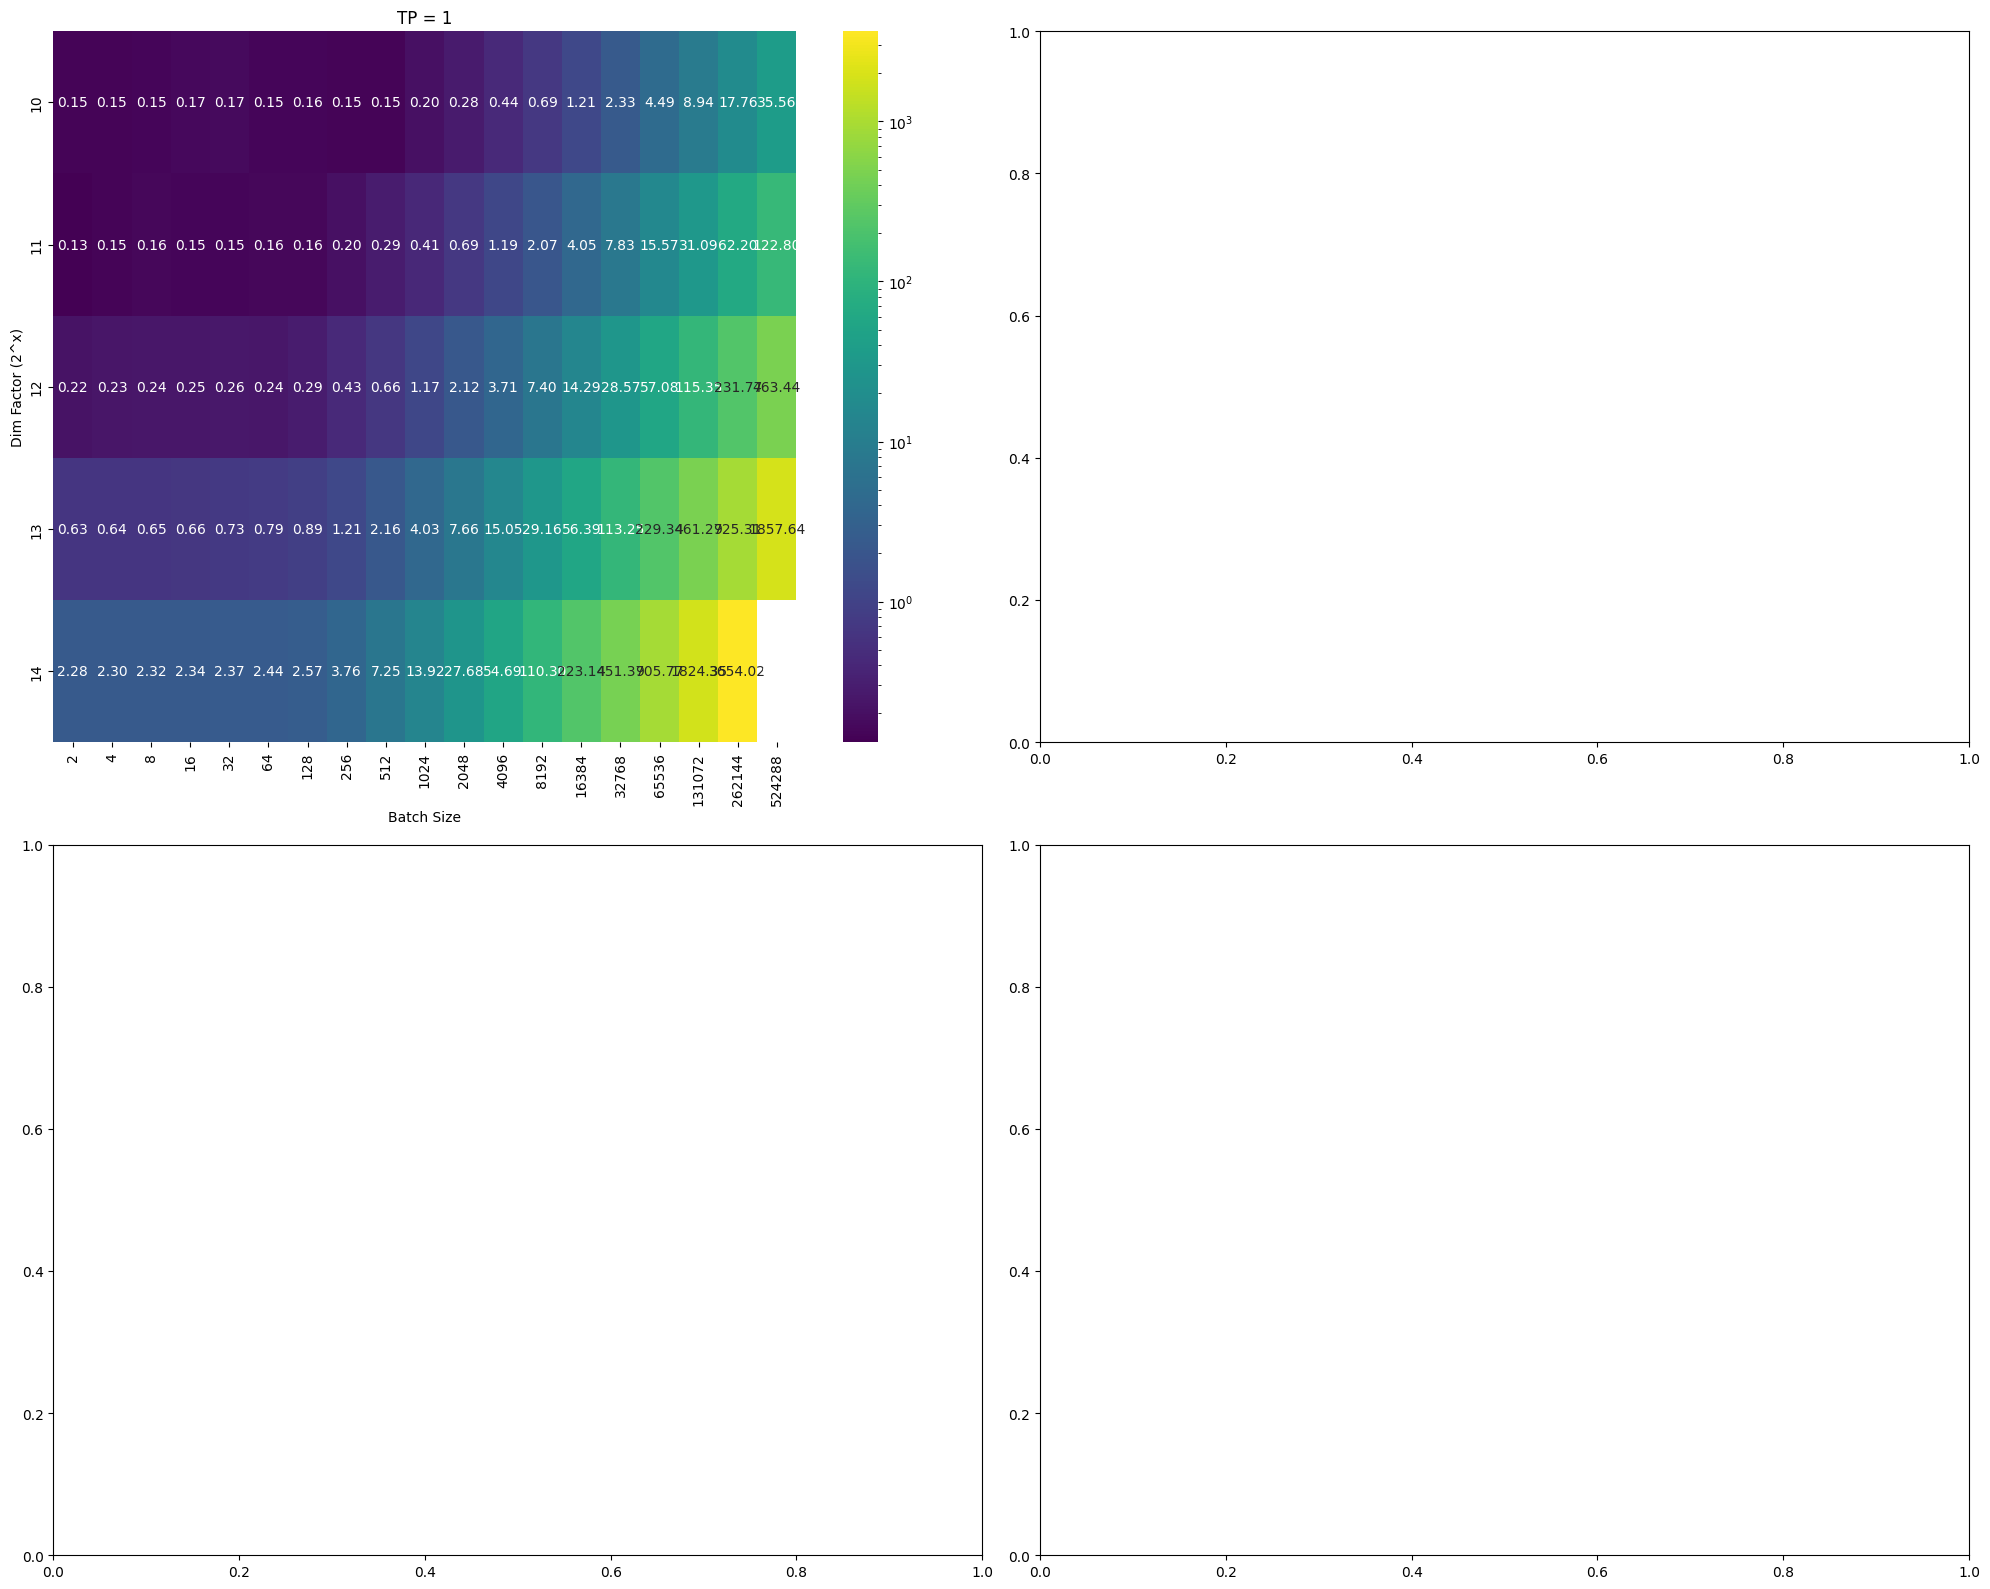

In [16]:
compiled_dict # (batch_size, dim_factor, tp) -> (avg_time, std_time)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for tp_idx, tp in enumerate([1, 2, 4, 8]):
    try:
        # Extract data for this tp
        data = []
        batch_sizes = []
        dim_factors = []
        
        for (bs_factor, df, t, dratio), (avg_time, _) in compiled_dict.items():
            bs = 2 ** bs_factor
            if t == tp:
                data.append(avg_time)
                if bs not in batch_sizes:
                    batch_sizes.append(bs)
                if df not in dim_factors:
                    dim_factors.append(df)
        
        batch_sizes.sort()
        dim_factors.sort()
        
        # Create 2D array for heatmap
        heatmap_data = np.zeros((len(dim_factors), len(batch_sizes)))
        for (bs_factor, df, t, dratio), (avg_time, _) in compiled_dict.items():
            bs = 2 ** bs_factor
            if t == tp:
                i = dim_factors.index(df)
                j = batch_sizes.index(bs)
                heatmap_data[i,j] = avg_time
        
        # Plot heatmap
        sns.heatmap(
            heatmap_data,
            ax=axes[tp_idx],
            xticklabels=batch_sizes,
            yticklabels=dim_factors,
            cmap='viridis',
            norm='log',
            annot=True,
            fmt='.2f'
        )
        
        axes[tp_idx].set_title(f'TP = {tp}')
        axes[tp_idx].set_xlabel('Batch Size')
        axes[tp_idx].set_ylabel('Dim Factor (2^x)')
    except Exception as e:
        pass

plt.tight_layout()
plt.show()


/tmp/ipykernel_545804/2072033524.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[tp_idx].legend()


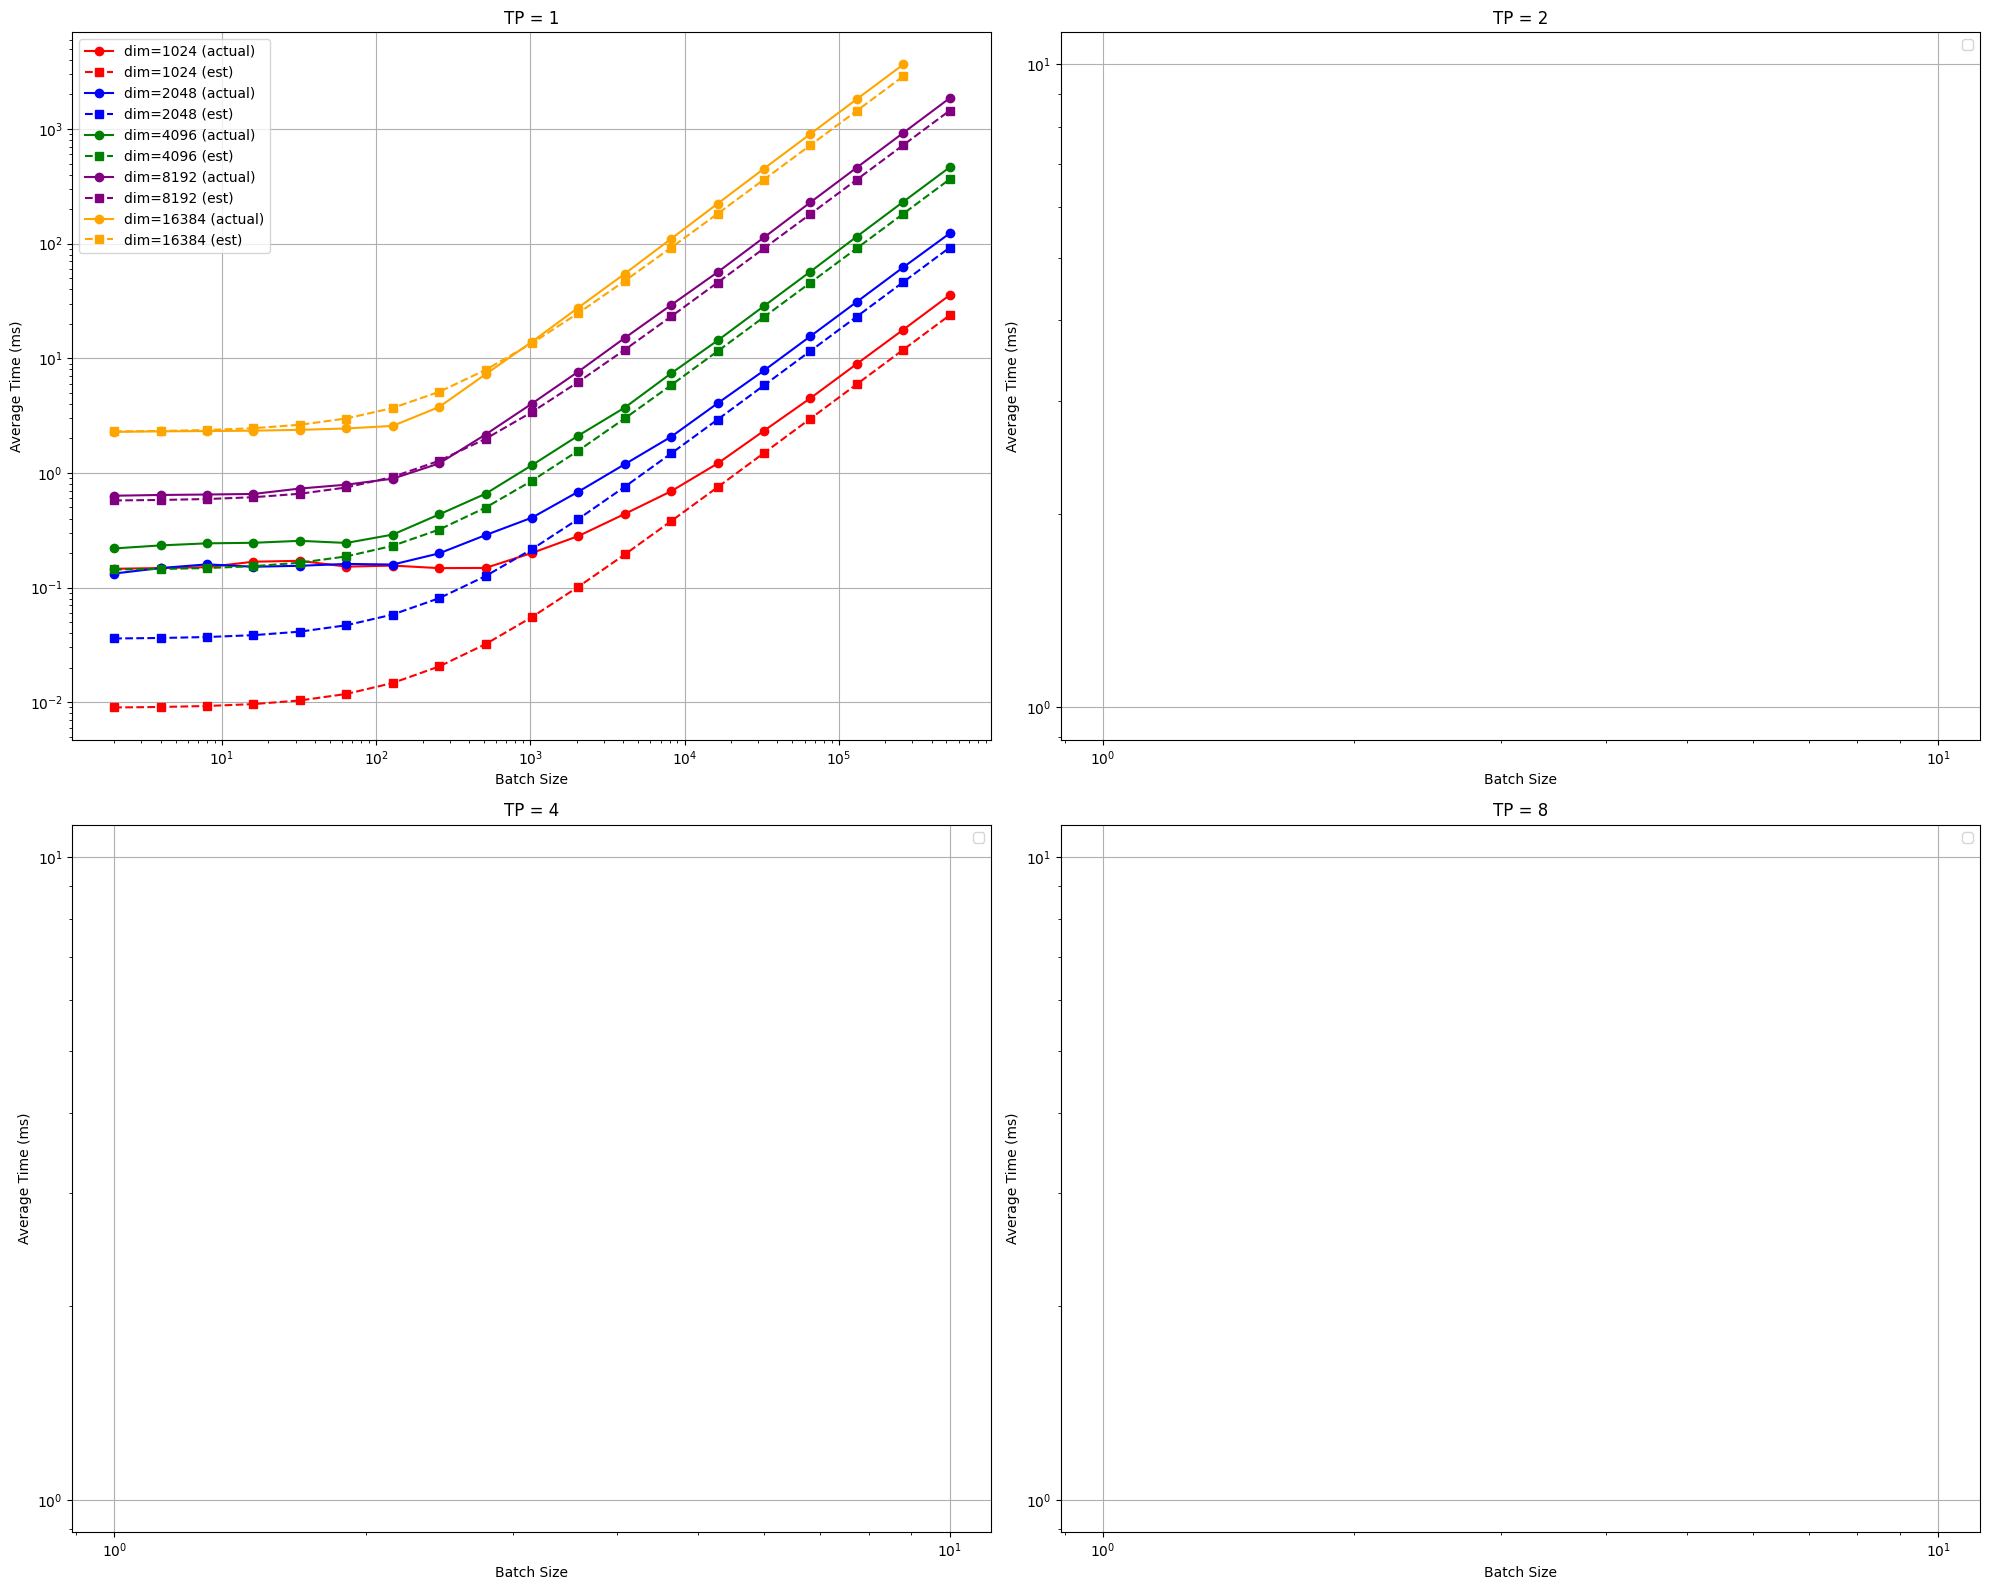

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for tp_idx, tp in enumerate([1, 2, 4, 8]):
    try:
        # Extract data for this tp
        data_by_dim = {}
        data_by_dim_est = {}
        batch_sizes = []
        
        for (bs_factor, df, t, dratio), (avg_time, _) in compiled_dict.items():
            bs = 2 ** bs_factor
            if t == tp:
                if bs not in batch_sizes:
                    batch_sizes.append(bs)
                dim = 2**df
                if dim not in data_by_dim:
                    data_by_dim[dim] = []
                    data_by_dim_est[dim] = []

                data_by_dim[dim].append((bs, avg_time))
                est_time = get_est_time(bs, dim, dim * dratio, dtype_size=2)
                data_by_dim_est[dim].append((bs, est_time))
        
        batch_sizes.sort()
        
        # Plot lines for each dim
        for idx, (dim, points) in enumerate(data_by_dim.items()):
            points.sort(key=lambda x: x[0])  # Sort by batch size
            x = [p[0] for p in points]
            y = [p[1] for p in points]
            axes[tp_idx].plot(x, y, marker='o', label=f'dim={dim} (actual)', color=colors[idx])
            
            # Add estimated time curve
            est_points = data_by_dim_est[dim]
            est_points.sort(key=lambda x: x[0])  # Sort by batch size
            x_est = [p[0] for p in est_points]
            y_est = [p[1] for p in est_points]
            axes[tp_idx].plot(x_est, y_est, marker='s', linestyle='--', label=f'dim={dim} (est)', color=colors[idx])
        
        axes[tp_idx].set_title(f'TP = {tp}')
        axes[tp_idx].set_xlabel('Batch Size')
        axes[tp_idx].set_ylabel('Average Time (ms)')
        axes[tp_idx].set_xscale('log')
        axes[tp_idx].set_yscale('log')
        axes[tp_idx].grid(True)
        axes[tp_idx].legend()
    except Exception as e:
        print(e)
        pass

plt.tight_layout()
plt.show()


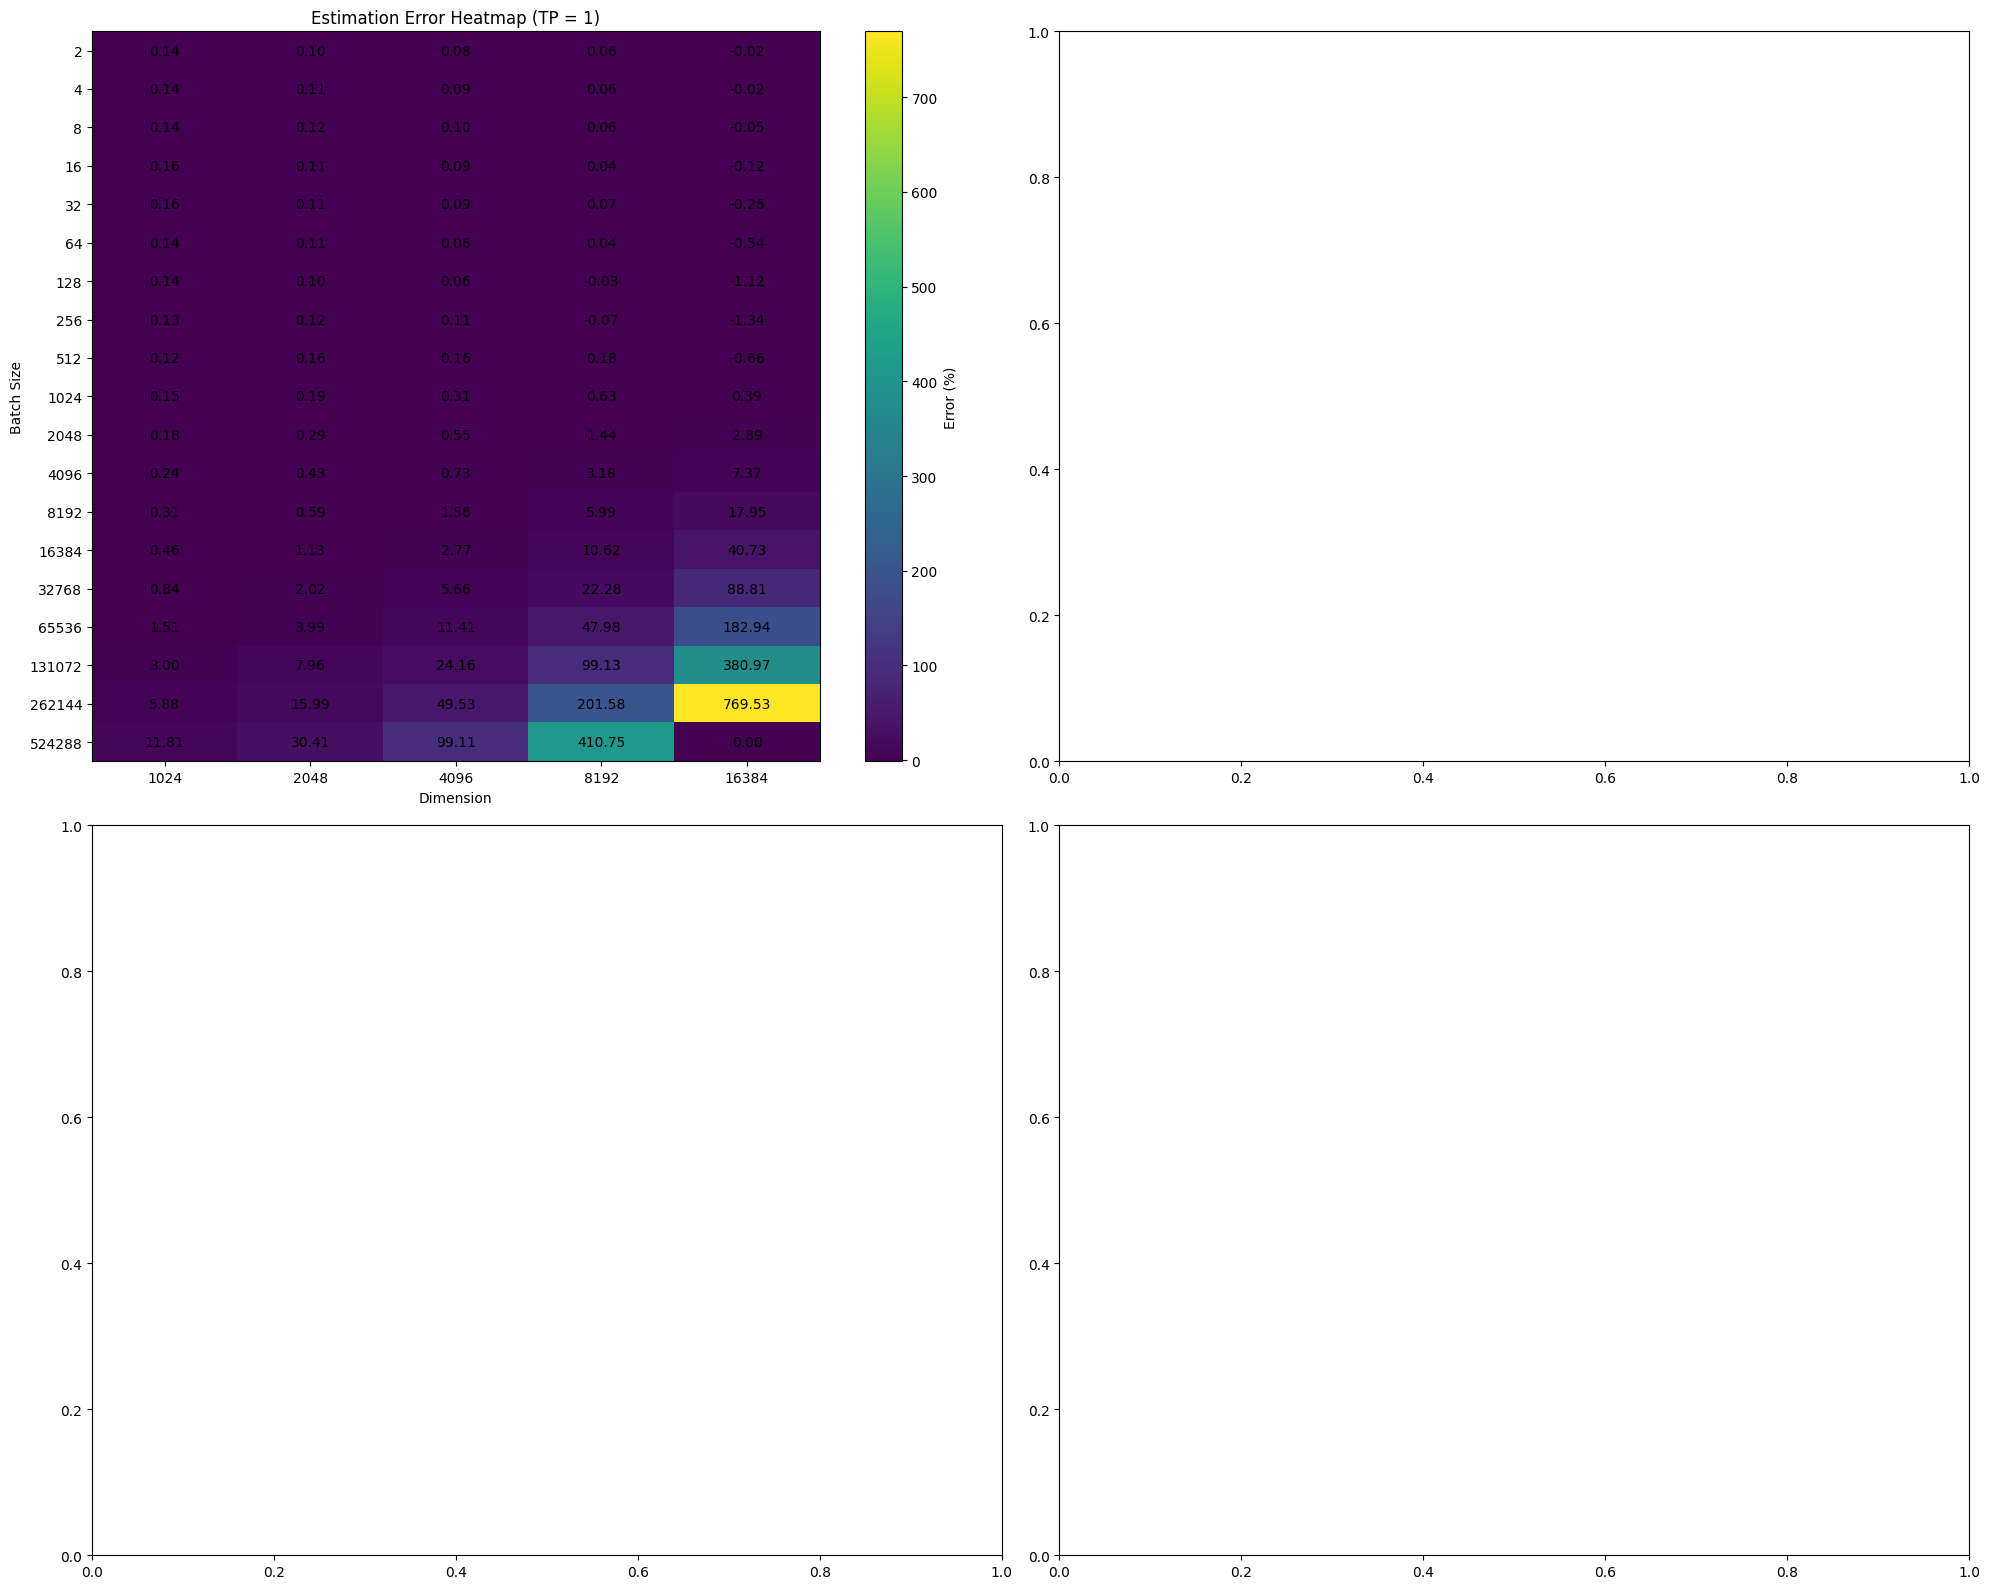

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for tp_idx, tp in enumerate([1, 2, 4, 8]):
    try:
        # Extract data for this tp
        data_points = []
        dims = set()
        batch_sizes = set()
        
        # Collect data points and unique dims/batch sizes
        for (bs_factor, df, t, dratio), (avg_time, _) in compiled_dict.items():
            if t == tp:
                bs = 2 ** bs_factor
                dim = 2**df
                est_time = get_est_time(bs, dim, dim * dratio, dtype_size=2)
                # Calculate relative error
                # error = abs(avg_time - est_time) / avg_time * 100  # Error as percentage
                error = avg_time - est_time
                data_points.append((dim, bs, error))
                dims.add(dim)
                batch_sizes.add(bs)
        
        if not data_points:
            continue
            
        # Convert to sorted lists
        dims = sorted(list(dims))
        batch_sizes = sorted(list(batch_sizes))
        
        # Create error matrix
        error_matrix = np.zeros((len(batch_sizes), len(dims)))
        for dim, bs, error in data_points:
            i = batch_sizes.index(bs)
            j = dims.index(dim)
            error_matrix[i, j] = error
            
        # Create heatmap
        im = axes[tp_idx].imshow(error_matrix, aspect='auto', cmap='viridis')
        
        # Set ticks and labels
        axes[tp_idx].set_xticks(range(len(dims)))
        axes[tp_idx].set_yticks(range(len(batch_sizes)))
        axes[tp_idx].set_xticklabels(dims)
        axes[tp_idx].set_yticklabels(batch_sizes)

        # Set annotation text
        for i in range(len(batch_sizes)):
            for j in range(len(dims)):
                axes[tp_idx].text(j, i, f'{error_matrix[i, j]:.2f}', ha='center', va='center', color='black')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[tp_idx], label='Error (%)')
        
        axes[tp_idx].set_title(f'Estimation Error Heatmap (TP = {tp})')
        axes[tp_idx].set_xlabel('Dimension')
        axes[tp_idx].set_ylabel('Batch Size')
        
    except Exception as e:
        print(f"Error for TP={tp}:", e)
        pass

plt.tight_layout()
plt.show()


/tmp/ipykernel_545804/3433629536.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[tp_idx].legend()


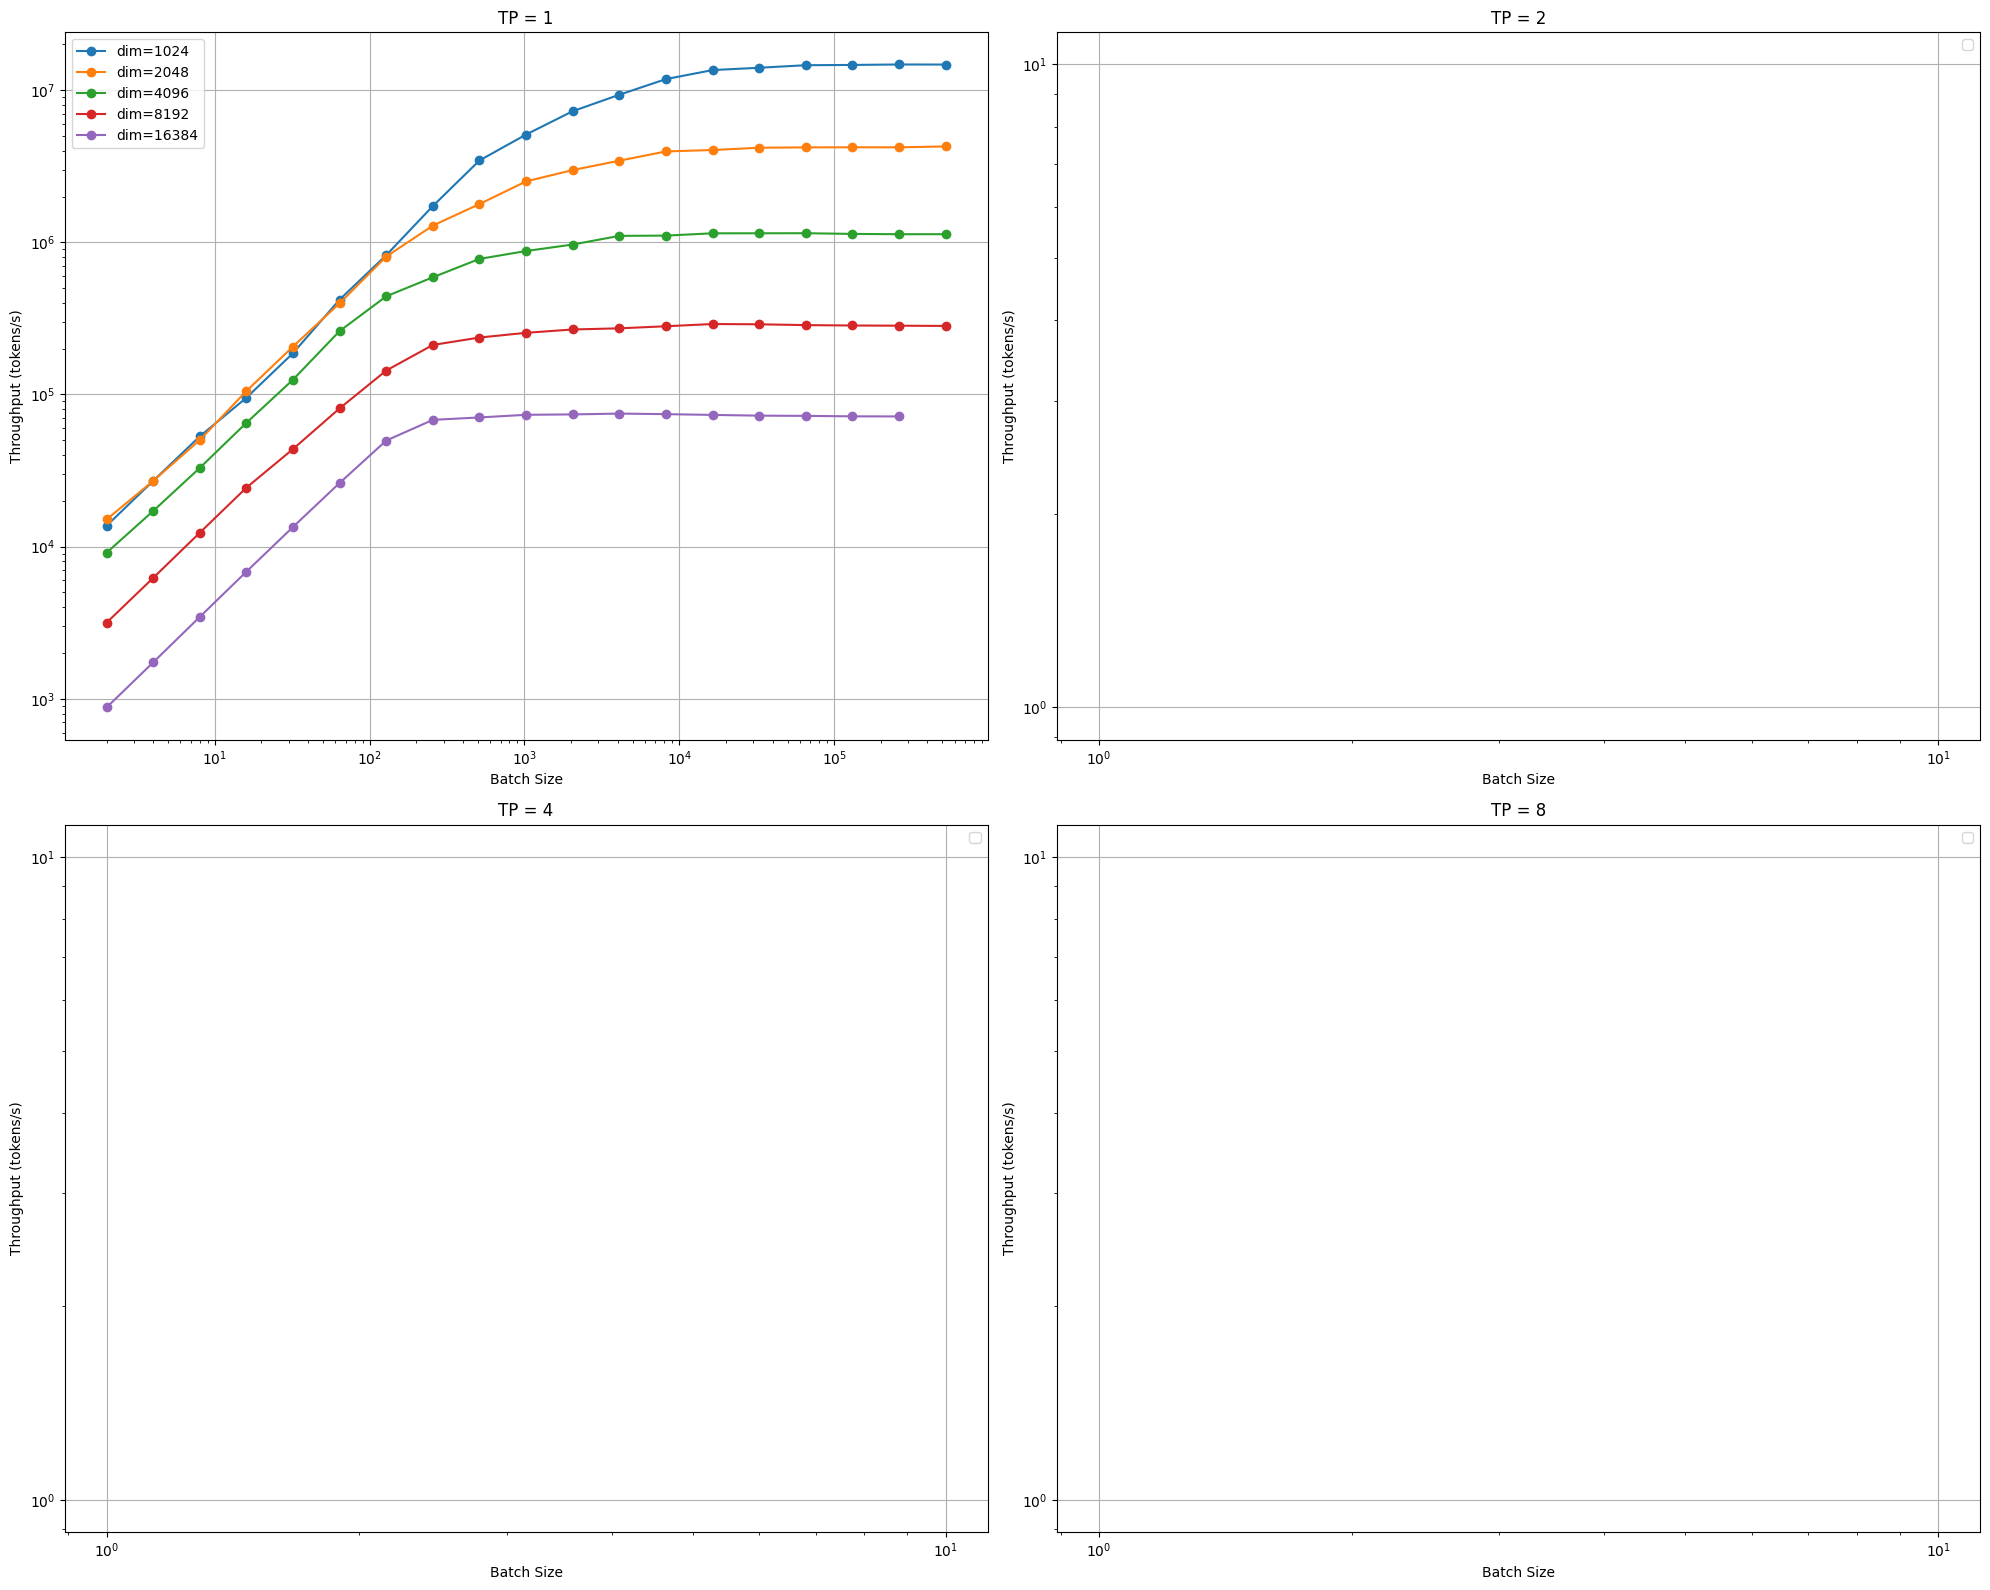

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for tp_idx, tp in enumerate([1, 2, 4, 8]):
    try:
        # Extract data for this tp
        data_by_dim = {}
        batch_sizes = []
        
        for (bs_factor, df, t, dratio), (avg_time, std_time) in compiled_dict.items():
            bs = 2 ** bs_factor
            if t == tp:
                if bs not in batch_sizes:
                    batch_sizes.append(bs)
                dim = 2**df
                if dim not in data_by_dim:
                    data_by_dim[dim] = []
                throughput = bs / avg_time * 1000
                data_by_dim[dim].append((bs, throughput))
        
        batch_sizes.sort()
        
        # Plot lines for each dim
        for dim, points in data_by_dim.items():
            points.sort(key=lambda x: x[0])  # Sort by batch size
            x = [p[0] for p in points]
            y = [p[1] for p in points]
            axes[tp_idx].plot(x, y, marker='o', label=f'dim={dim}')
        
        axes[tp_idx].set_title(f'TP = {tp}')
        axes[tp_idx].set_xlabel('Batch Size')
        axes[tp_idx].set_ylabel('Throughput (tokens/s)')
        axes[tp_idx].set_xscale('log')
        axes[tp_idx].set_yscale('log')
        axes[tp_idx].grid(True)
        axes[tp_idx].legend()
    except Exception as e:
        pass

plt.tight_layout()
plt.show()


In [18]:
mlp_ai_data = {}
scale_factor = 3.5
for batch_size_factor in range(1, 20):
    for dim_factor in range(10, 16):
        batch_size = 2 ** batch_size_factor
        dim_size = 2 ** dim_factor
        in_dim = dim_size
        out_dim = (in_dim * scale_factor)
        mlp_ai_data[(batch_size, dim_size)] = mlp_ai(batch_size, in_dim, out_dim, dtype_size=2)

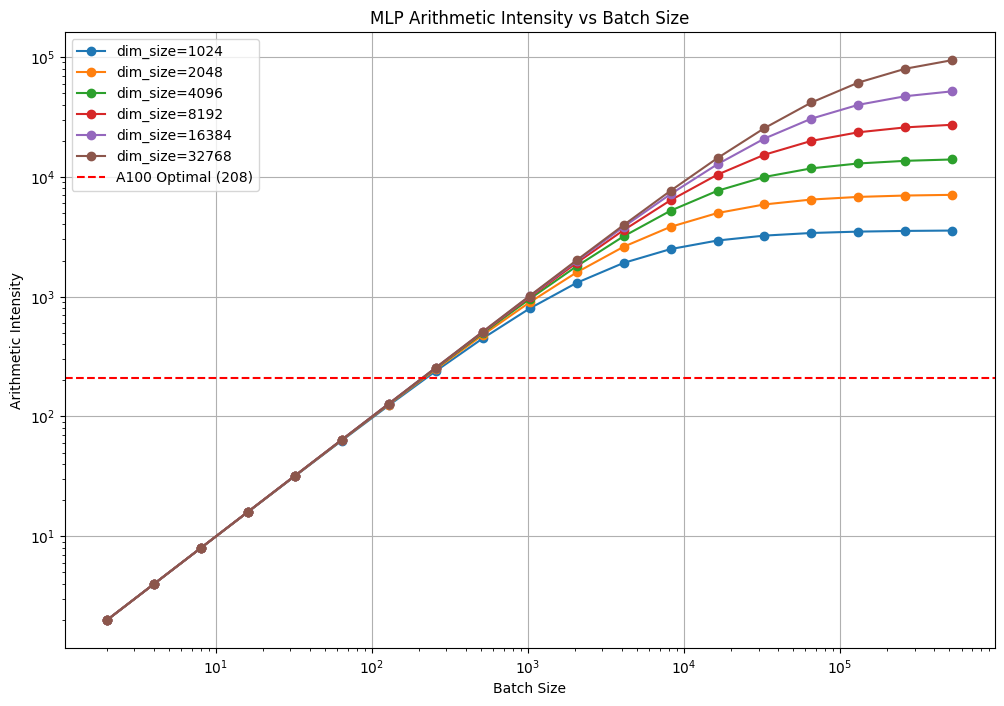

In [19]:
import matplotlib.pyplot as plt
# Group data by dim_size
dim_sizes = sorted(list(set(k[1] for k in mlp_ai_data.keys())))
batch_sizes = sorted(list(set(k[0] for k in mlp_ai_data.keys())))

plt.figure(figsize=(12,8))
for dim_size in dim_sizes:
    values = [mlp_ai_data[(bs, dim_size)] for bs in batch_sizes]
    plt.plot(batch_sizes, values, label=f'dim_size={dim_size}', marker='o')

# Add A100 optimal line
a100_optimal = 312 / 1.5
plt.axhline(y=a100_optimal, color='r', linestyle='--', label='A100 Optimal (208)')

plt.xlabel('Batch Size')
plt.ylabel('Arithmetic Intensity')
plt.title('MLP Arithmetic Intensity vs Batch Size')
plt.xscale('log')
plt.yscale('log') 
plt.grid(True)
plt.legend()
plt.show()

In [1]:
import numpy

In [2]:
import pickle

In [6]:
with open("mlp.data.pkl", "rb") as f:
    mlp_data = pickle.load(f)

In [15]:
# mlp_data # (batch_size_factor, dim_factor, tp, dim_ratio)
mlp_data_d4096 = {
    key: item[0]
    for key, item in mlp_data.items() if key[1] == 12
}

In [16]:
mlp_data_d4096

{(1, 12, 1, 3.5): 0.219379198551178,
 (2, 12, 1, 3.5): 0.23313920199871063,
 (3, 12, 1, 3.5): 0.24302720427513122,
 (4, 12, 1, 3.5): 0.24567039906978608,
 (5, 12, 1, 3.5): 0.2555776059627533,
 (6, 12, 1, 3.5): 0.24492799937725068,
 (7, 12, 1, 3.5): 0.2896384060382843,
 (8, 12, 1, 3.5): 0.4341823995113373,
 (9, 12, 1, 3.5): 0.6577152013778687,
 (10, 12, 1, 3.5): 1.1675328016281128,
 (11, 12, 1, 3.5): 2.116428804397583,
 (12, 12, 1, 3.5): 3.7137983798980714,
 (13, 12, 1, 3.5): 7.395155239105224,
 (14, 12, 1, 3.5): 14.289766311645508,
 (15, 12, 1, 3.5): 28.565638732910156,
 (16, 12, 1, 3.5): 57.07596206665039,
 (17, 12, 1, 3.5): 115.34554290771484,
 (18, 12, 1, 3.5): 231.7682342529297,
 (19, 12, 1, 3.5): 463.435791015625}

In [18]:
import numpy as np

In [20]:
# (tp_degree_log, num_token_log)
mlp_matrix = np.ones((4, 20))

In [23]:
for (bs, _, _, _), duration in mlp_data_d4096.items():
    mlp_matrix[0, bs] = duration
    mlp_matrix[1, bs] = duration / 2
    mlp_matrix[2, bs] = duration / 4
    mlp_matrix[3, bs] = duration / 8
    pass

In [26]:
np.save("mlp_time.npy", mlp_matrix)


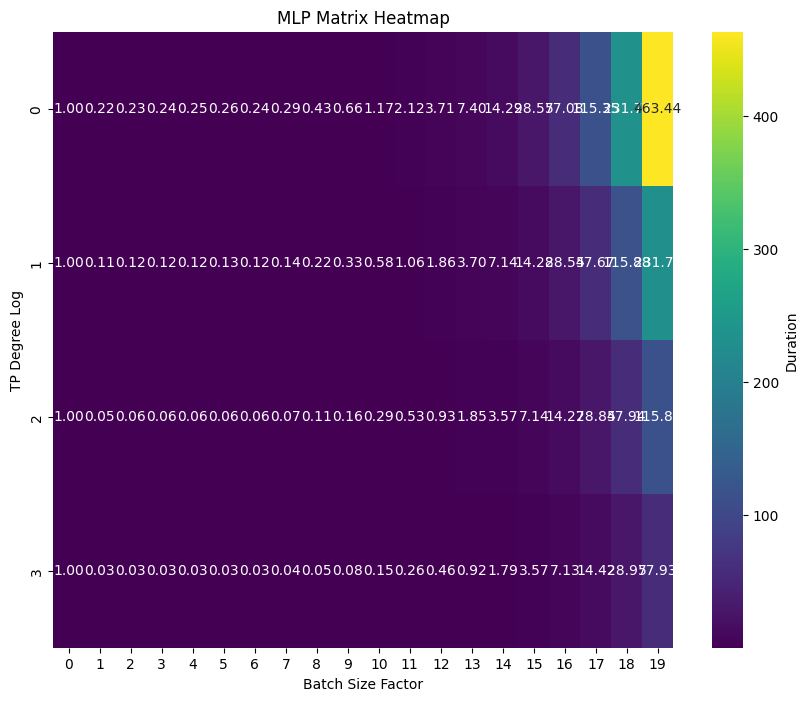

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(mlp_matrix, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Duration'})
plt.title("MLP Matrix Heatmap")
plt.xlabel("Batch Size Factor")
plt.ylabel("TP Degree Log")
plt.show()


In [29]:
import pandas as pd
attn_df = pd.read_csv("per_doc_cp_attn.table.qo-32_kv-32_d-128.txt", skiprows=2)

In [32]:
len(attn_df.sf.unique())

18

In [37]:
attn_df # -> (tp_degree_log, cp_degree_log, seq_len_log)
attn_matrix = np.ones((4, 4, 8))
for index, row in attn_df.iterrows():
    tp_log = np.log2(row['tp'])
    cp_log = np.log2(row['cp'])
    sf_log = np.log2(row['sf'])
    
    # Check if all logs are integers
    if tp_log.is_integer() and cp_log.is_integer() and sf_log.is_integer():
        tp_log = int(tp_log)
        cp_log = int(cp_log)
        sf_log = int(sf_log)
        
        # Insert into attn_matrix
        attn_matrix[tp_log, cp_log, sf_log] = row['fwd']


In [39]:
np.save("attn_matrix.npy", attn_matrix)


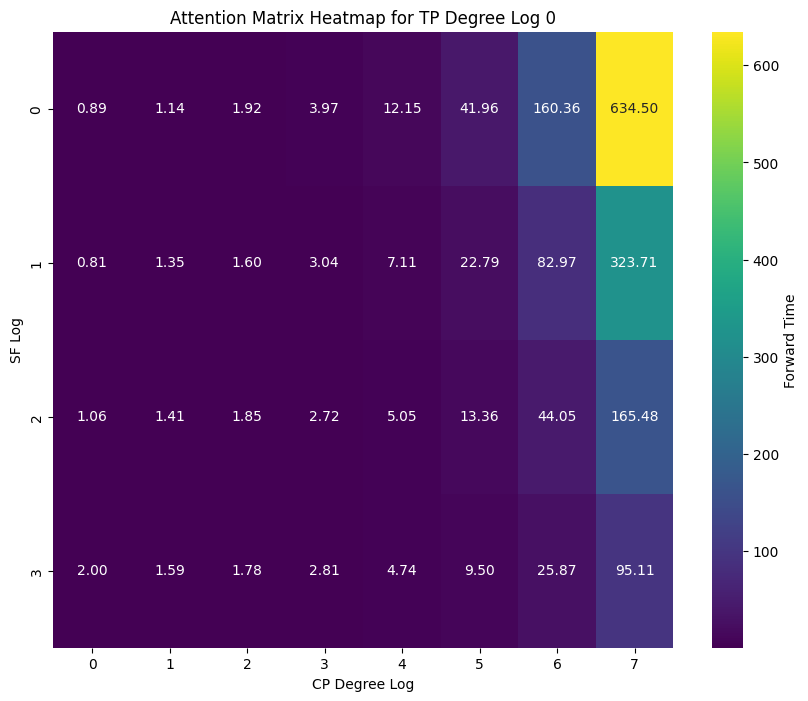

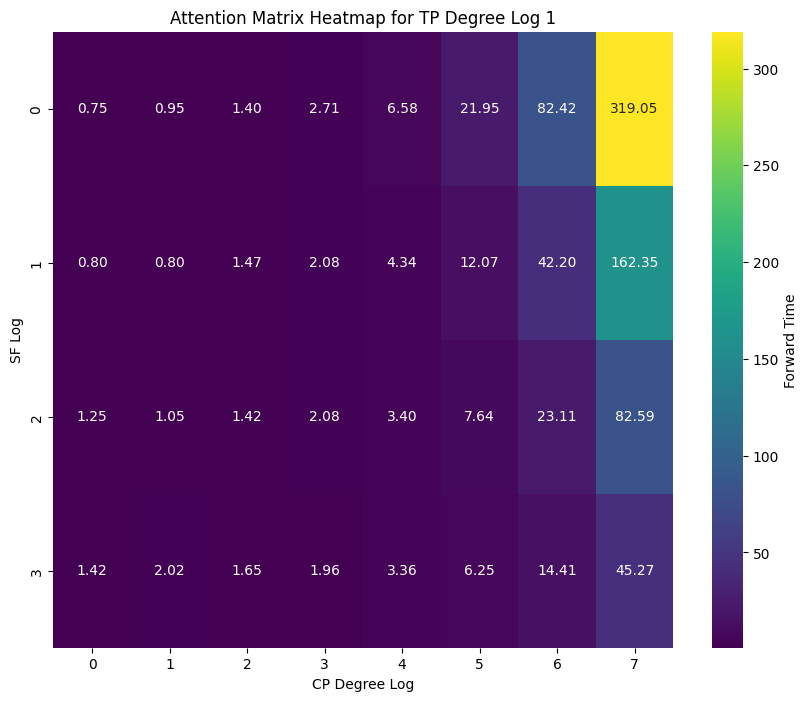

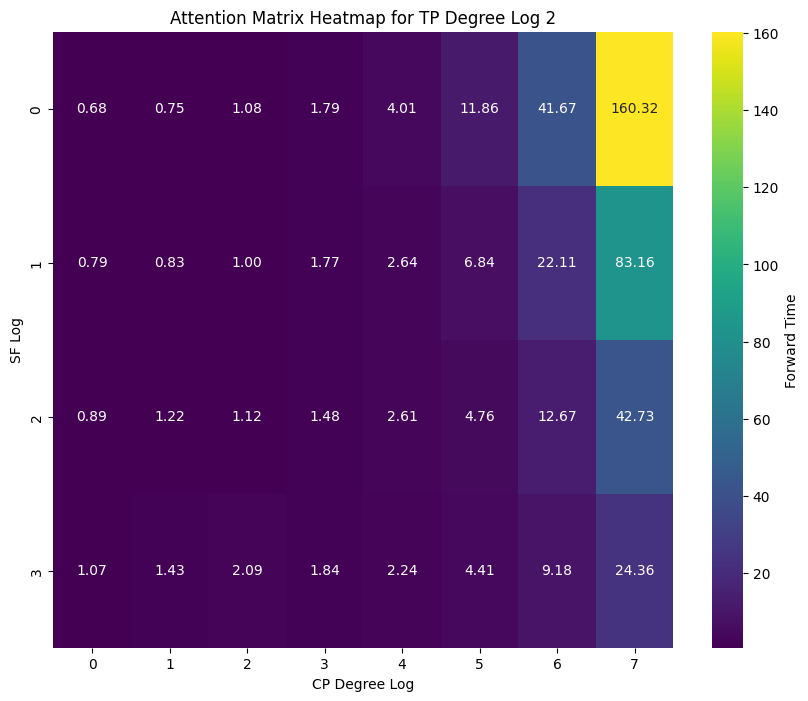

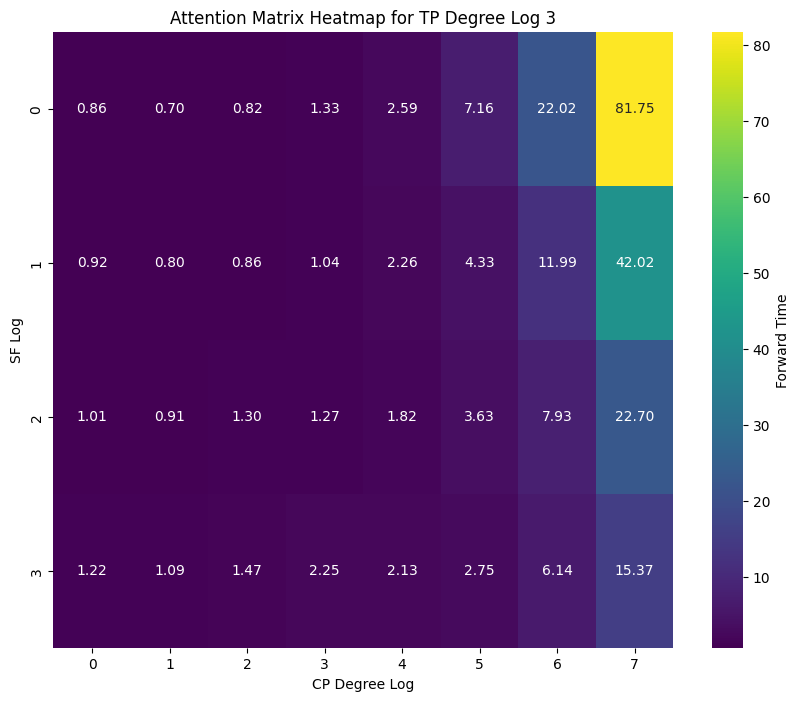

In [38]:
for tp_idx in range(attn_matrix.shape[0]):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_matrix[tp_idx], annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Forward Time'})
    plt.title(f"Attention Matrix Heatmap for TP Degree Log {tp_idx}")
    plt.xlabel("CP Degree Log")
    plt.ylabel("SF Log")
    plt.show()
